<a href="https://colab.research.google.com/github/chrstnplcls/Research/blob/main/CoinCNet_100_3S_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q tensorflow-addons
!pip install patool

from tensorflow.keras import layers
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
import patoolib

     |████████████████████████████████| 1.1 MB 37.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 5.4 MB/s 


# Load Dataset

In [4]:
drive.mount("/content/gdrive")
!mkdir "/content/Coin_Train"
!mkdir "/content/Coin_Test"
patoolib.extract_archive("/content/gdrive/MyDrive/Coin_Train.rar", outdir="/content/Coin_Train")
patoolib.extract_archive("/content/gdrive/MyDrive/Coin_Test.rar", outdir="/content/Coin_Test")

Mounted at /content/gdrive
patool: Extracting /content/gdrive/MyDrive/Coin_Train.rar ...
patool: running /usr/bin/unrar x -- /content/gdrive/MyDrive/Coin_Train.rar
patool:     with cwd='/content/Coin_Train'
patool: ... /content/gdrive/MyDrive/Coin_Train.rar extracted to `/content/Coin_Train'.
patool: Extracting /content/gdrive/MyDrive/Coin_Test.rar ...
patool: running /usr/bin/unrar x -- /content/gdrive/MyDrive/Coin_Test.rar
patool:     with cwd='/content/Coin_Test'
patool: ... /content/gdrive/MyDrive/Coin_Test.rar extracted to `/content/Coin_Test'.


'/content/Coin_Test'

In [4]:
!mkdir "/content/TEST_Fin"
patoolib.extract_archive("/content/gdrive/MyDrive/TEST_Fin.rar", outdir="/content/TEST_Fin")

PatoolError: ignored

In [5]:
image_res = (100,100);
batch_size= 32
path2ds = "/content/Coin_Train"
path2ts = "/content/Coin_Test"

train = keras.utils.image_dataset_from_directory(
    directory=path2ds,
    validation_split = 0.3,
    subset = "training",
    seed=22,
    labels='inferred',
    label_mode='categorical',
    interpolation='gaussian',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=image_res)

valid = keras.utils.image_dataset_from_directory(
    directory=path2ds,
    validation_split = 0.3,
    subset = "validation",
    seed=22,
    labels='inferred',
    label_mode='categorical',
    interpolation='gaussian',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=image_res)

test = keras.utils.image_dataset_from_directory(
    directory=path2ts,
    labels='inferred',
    label_mode='categorical',
    interpolation='gaussian',
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    image_size=image_res)



Found 25620 files belonging to 12 classes.
Using 17934 files for training.
Found 25620 files belonging to 12 classes.
Using 7686 files for validation.
Found 5755 files belonging to 12 classes.


In [6]:
num_classes = 12
input_shape = (image_res[0], image_res[1], 3)
positional_emb = True
num_output_channels = 64
num_stages = 3
num_MBLayers = 6
num_heads = 2
transformer_layers = 3
key_dimension = 128
stochastic_depth_rate = 0.1
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
image_size = input_shape[0]
conv_layers = 1
checkpoint_fp = "/content/CoinCNet 100-3S LONG.h5"

# CoinCNet

In [7]:
def positional_embedding(image_size):
  if positional_emb:
    dummy_inputs = tf.ones((1, image_size, image_size, 3))
    dummy_outputs, _ = tokenize(dummy_inputs)
    sequence_length = tf.shape(dummy_outputs)[1]
    projection_dim = tf.shape(dummy_outputs)[-1]
    embed_layer = layers.Embedding(input_dim=sequence_length, output_dim=projection_dim)
    return embed_layer, sequence_length
  else:
    return None

def MBConv(x, expand=64, downsample=False, s = 1):
  channels = x.shape[-1]
  y = layers.Conv2D(expand, (1,1), trainable=False)(x)
  y = layers.BatchNormalization()(y)      
  y = layers.Activation('relu')(y)  
  y = layers.DepthwiseConv2D((3,3), strides=(s, s), padding="same", trainable=False)(y)   
  y = layers.BatchNormalization()(y)  
  y = layers.Activation('relu')(y)    
  y = layers.Conv2D(channels, kernel_size=1, strides=(1,1), trainable=False)(y)  
  y = layers.BatchNormalization()(y)  
  return layers.Add()([x, y])

def tokenize(img, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2, num_output_channels=num_output_channels,):
  base = layers.Conv2D(64, kernel_size, 2, padding="valid", use_bias=False, activation="relu", kernel_initializer="he_normal", trainable=False)(img)
  base = layers.Activation('relu')(base)  
  base = layers.BatchNormalization()(base)  
  for i in range(num_stages):
    if i < 1:
      base = layers.Conv2D(num_output_channels, kernel_size, stride, padding="same", activation="relu", kernel_initializer="he_normal", trainable=False)(base)
      base = layers.Activation('relu')(base)  
      base = layers.BatchNormalization()(base)  
    else:
      downsample = False
      for j in range(num_MBLayers):
        if j == num_MBLayers - 1:
          downsample = True
        base = MBConv(x=base, downsample=downsample)
      base = layers.ZeroPadding2D(padding)(base)
      base = layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")(base)
      base_dim = base.shape[-1]
  sequence = tf.reshape(base, (-1, tf.shape(base)[1] * tf.shape(base)[2], tf.shape(base)[-1]),)
  return sequence, base_dim

In [8]:
def MLP(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential([layers.RandomRotation(factor = (-0.9,0.9)) ], name="data_augmentation",)

class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def create_model(image_size=image_size, input_shape=input_shape, num_heads=num_heads, key_dimension=key_dimension):
    inputs = layers.Input(input_shape)
    augmented = data_augmentation(inputs)
    encoded_patches, projection_dim = tokenize(augmented)
    transformer_units = [projection_dim, projection_dim]
    
    if positional_emb:
        pos_embed, seq_length = positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]
    
    for i in range(transformer_layers):
        x_value = x_key = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        x_key = layers.Dense(key_dimension)(x_key)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x_value, x_key)
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = MLP(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(attention_weights, representation, transpose_a=True)
    weighted_representation = tf.squeeze(weighted_representation, -2)
    output = layers.Dense(num_classes, activation="softmax")(weighted_representation)
    model = keras.Model(inputs=inputs, outputs=output)
    return model

# Training

In [ ]:
num_epochs = 15
metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"), keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),]
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    model.compile(
        optimizer=optimizer,loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),metrics=metrics,)
    checkpoint_filepath = checkpoint_fp
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    #model.load_weights(checkpoint_filepath)
    history = model.fit(
        train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=valid,
        callbacks=[checkpoint_callback],
    )
    return history
model = create_model()
history = run_experiment(model)

# Evaluation

In [ ]:
create_model().summary()

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x),axis=1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

conf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

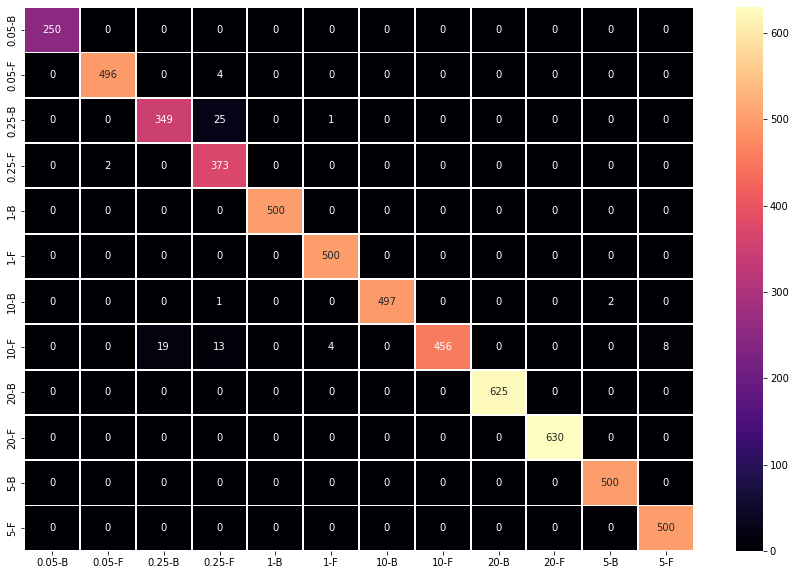

In [ ]:
import seaborn as sns
import pandas as pd

labels = test.class_names

conf = pd.DataFrame(conf, index = labels, columns = labels)
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(conf, linewidths=1, annot=True, ax=ax, fmt='g', cmap="magma")
fig.savefig("heatmap.svg") 

In [ ]:
def pred(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=[keras.metrics.CategoricalAccuracy(name="accuracy"), keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),],)
    checkpoint_filepath = checkpoint_fp
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

model = create_model()
evaluate = pred(model)

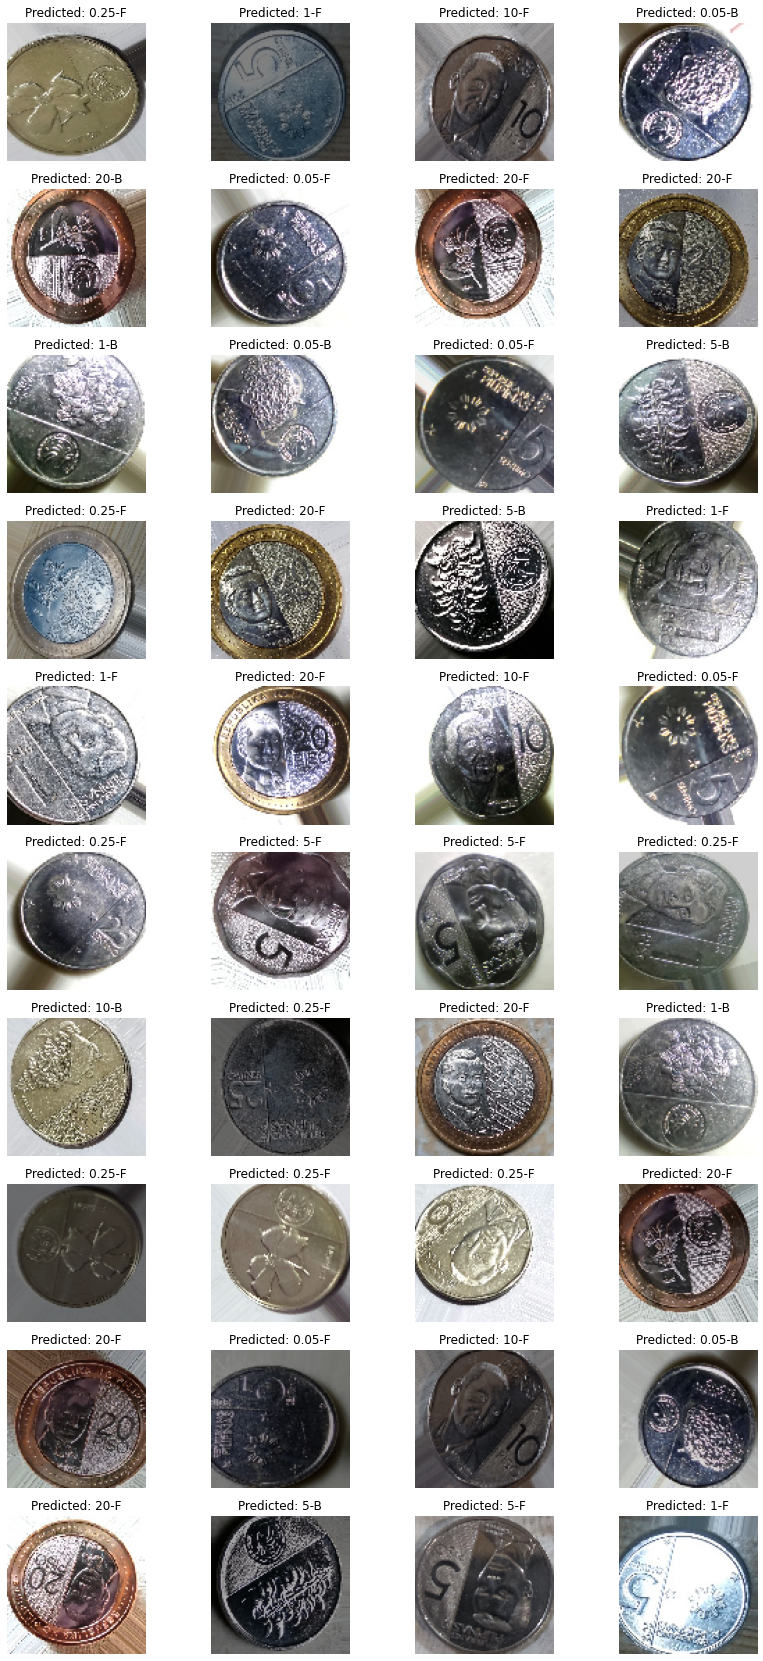

In [ ]:
from keras.preprocessing import image
classes = test.class_names


fig, axs = plt.subplots(10, 4, figsize = (14, 30))
c = 1
for i in range(10):
  for j in range(4):

    img = image.load_img("/content/Presentation/Coin (" + str(c) + ").jpg", target_size=(100, 100))
    x = image.img_to_array(img)
    axs[i, j].imshow(img)
    x = np.expand_dims(x, axis=0)
    x = classes[np.argmax(model.predict(x))]
    axs[i, j].set_title("Predicted: " + str(x));  axs[i, j].axis("off")
    c+=1
fig.savefig('/content/Pred.svg', dpi=300)


#Application


In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from PIL import Image, ImageEnhance
import glob

In [9]:
def calculate_total(pred_list):
  out = 0
  calc_dict = {
      "0.05F": 0.05, "0.05B": 0.05,
      "0.25F": 0.25, "0.25B": 0.25,
      "1F": 1, "1B": 1,
      "5F": 5, "5B": 5,
      "10F": 10, "10B": 10,
      "20F": 20, "20B": 20
               }
  num = len(pred_list)
  for i in range(num):
    out = out + calc_dict[pred_list[i]]

  return out

In [10]:
model = create_model()
model.load_weights('/content/CoinCNet-100-3S-LONG.h5')
classes = ["1B", "0.05F", "0.25B", "0.25F", "1B", "1F", "10B", "10F", "20B", "20F", "20F", "5F"]

#CHT Masking

In [ ]:
check = cv2.imread('/content/coins.jpg')
plt.imshow(check)
plt.axis('off')

In [ ]:

image = cv2.imread('/content/coins.jpg')


image = cv2.resize(image, (600, 600))

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


circles = cv2.HoughCircles(gray,
                           cv2.HOUGH_GRADIENT,
                           1,
                           90,
                           param1=60,
                           param2=60,
                           minRadius=40,
                           maxRadius=90)

# Here are your circles:
circles = np.uint16(np.around(circles))

# Get input size:
dimensions = image.shape

# height, width
height = image.shape[0]
width = image.shape[1]

# Prepare a list to store each ROI:
circleROIs = []
for i in circles[0, :]:

    # Prepare a black canvas:
    canvas = np.zeros((height, width))

    # Draw the outer circle:
    color = (0, 255, 0)
    thickness = 2
    centerX = i[0]
    centerY = i[1]
    radius = i[2]
    #mark the CHT circle
    cv2.circle(image, (centerX, centerY), radius, color, thickness)
    #display image
cv2_imshow(image)

j = 0
imgList = []
for i in circles[0, :]:

    # Prepare a black canvas:
    canvas = np.zeros((height, width))
    
    color = (255, 255, 255)
    thickness = -1
    centerX = i[0]
    centerY = i[1]
    radius = i[2]

    #plot circles for cropping
    cv2.circle(canvas, (centerX, centerY), radius, color, thickness)

    # Create a copy of the input and mask input:
    imageCopy = image.copy()
    imageCopy[canvas == 0] = (0, 0, 0)

    # Crop the roi:
    x = centerX - radius
    y = centerY - radius
    h = 2 * radius
    w = 2 * radius

    croppedImg = imageCopy[y:y + h, x:x + w]

    # Store the ROI:
    circleROIs.append(croppedImg)
    
    image_name = 'myimage'+str(j)+'.jpg'
    cv2.imwrite(image_name, croppedImg)
    cv2_imshow(croppedImg)
    j+=1

#Classifier

In [ ]:
from keras.preprocessing import image
from PIL import Image, ImageEnhance
import glob

fig = plt.figure(figsize=(15, 9))
rows = 1
columns = j
nameList = []

for i in range(j):
  #LOAD IMAGE INTO IMG
  img = image.load_img('/content/myimage'+ str(i) + '.jpg', target_size=(100, 100))
  

  #CLASSIFICATION
  x = image.img_to_array(img)
  #x = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
  x = np.expand_dims(x, axis=0)
  pdct = (classes[np.argmax(model.predict(x))])

  #DISPLAY
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(pdct)

  #APPEND CLASSIFICATION INTO THE LIST TO FOR DECISION TREE
  nameList.append(pdct)


print("Total Value of Coins: ", calculate_total(nameList))

#Classifier

Total Value of Coins:  26.3


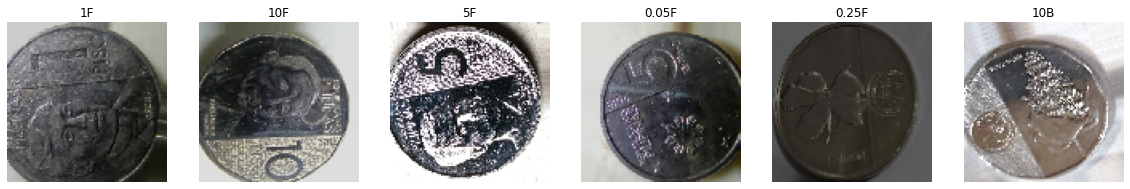

In [39]:

fig = plt.figure(figsize=(20, 12))
j = 6
rows = 1
columns = j
nameList = []

for i in range(j):
  #LOAD IMAGE INTO IMG
  img = image.load_img('/content/image'+ str(i+1) + '.jpg', target_size=(100, 100))
    

  #CLASSIFICATION
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  pdct = (classes[np.argmax(model.predict(x))])

  #DISPLAY
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(pdct)

  #APPEND CLASSIFICATION INTO THE LIST TO FOR DECISION TREE
  nameList.append(pdct)


print("Total Value of Coins: ", calculate_total(nameList))